In [1]:
%run ./function.ipynb

In [2]:
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A17_01_with_aggregated_txn_scenario_txn_type_key_營業日.csv"
df = pd.read_csv(PATH+FILE)

In [3]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [4]:
df['TO_SAR'].value_counts()

0    4434
1      73
Name: TO_SAR, dtype: int64

In [5]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (4507, 41)
total number of TO_SAR: 73
********************************
time interval in train set:2019-03-04~2020-06-24
TO_SAR in train set: 43
TO_SAR/Total in train set 0.015908250092489827
split dataset to train, test...
********************************
time interval in test set:2019-08-26~2020-12-31
TO_SAR in test set: 30
TO_SAR/Total in test set 0.01662971175166297
********************************
train data shape:  (2703, 40)
test data shape:  (1804, 40)


In [6]:
SAR = train_set[train_set['TO_SAR']!=0]
Non_SAR = train_set[train_set['TO_SAR']==0]

### threshold: 同一帳戶在1天移出交易(現金、支票、定存、黃金、轉帳、匯款)金額>=&1701_amount_dr元

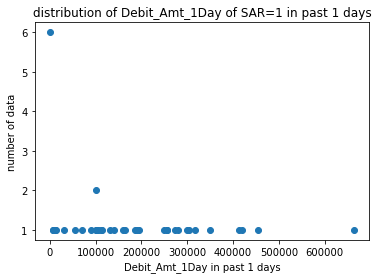

In [10]:
feature = 'Debit_Amt_1Day'
day = 1
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

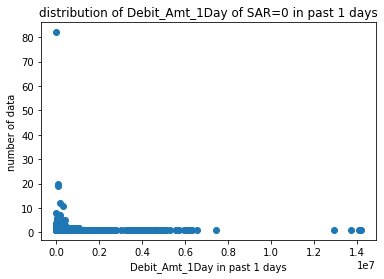

In [11]:
feature = 'Debit_Amt_1Day'
day = 1
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [13]:
# debit 提款, 小於等於{金額}留下, SAR=0 Debit_Amt_1Day值較大, upper bound
# train set 
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
threshold_range1 = np.arange(2e5, 2.2e6, 2e5)
for thre in threshold_range1:
    new_SAM_1 = train_set[train_set['Debit_Amt_1Day']<=thre] # <=threshold留下
    new_SAM_0 = train_set[train_set['Debit_Amt_1Day']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,200000.0,43,2660,30,1097,13,1563,0.6977,0.5831
1,400000.0,43,2660,39,1972,4,688,0.907,0.256
2,600000.0,43,2660,42,2314,1,346,0.9767,0.1284
3,800000.0,43,2660,43,2405,0,255,1.0,0.0943
4,1000000.0,43,2660,43,2454,0,206,1.0,0.0762
5,1200000.0,43,2660,43,2488,0,172,1.0,0.0636
6,1400000.0,43,2660,43,2510,0,150,1.0,0.0555
7,1600000.0,43,2660,43,2527,0,133,1.0,0.0492
8,1800000.0,43,2660,43,2537,0,123,1.0,0.0455
9,2000000.0,43,2660,43,2544,0,116,1.0,0.0429


In [14]:
# test set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 4e5

new_SAM_1 = test_set[test_set['Debit_Amt_1Day']<=thre] 
new_SAM_0 = test_set[test_set['Debit_Amt_1Day']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,400000.0,30,1774,27,1200,3,572,0.9,0.3187


### threshold: 存入交易(現金、支票、定存、黃金、轉帳、匯款)累計金額>=&1701_amount_cr元

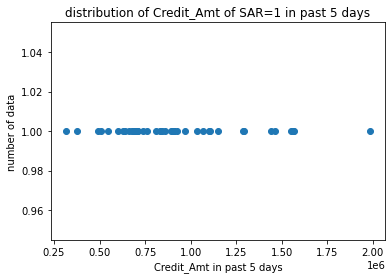

In [17]:
feature = 'Credit_Amt'
day = 5
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

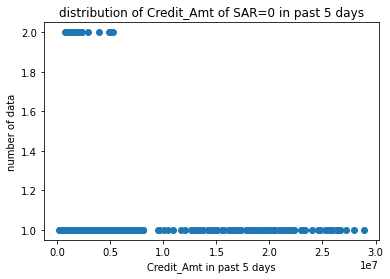

In [18]:
feature = 'Credit_Amt'
day = 5
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [19]:
# credit 存款, 小於等於{金額}留下, SAR=0 Credit_Amt值較大, upper bound
# train set 
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
threshold_range1 = np.arange(1e6, 1e7, 1e6)
for thre in threshold_range1:
    new_SAM_1 = train_set[train_set['Credit_Amt']<=thre] # <=threshold留下
    new_SAM_0 = train_set[train_set['Credit_Amt']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,1000000.0,43,2660,30,867,13,1793,0.6977,0.6681
1,2000000.0,43,2660,43,2154,0,506,1.0,0.1872
2,3000000.0,43,2660,43,2409,0,251,1.0,0.0929
3,4000000.0,43,2660,43,2444,0,216,1.0,0.0799
4,5000000.0,43,2660,43,2480,0,180,1.0,0.0666
5,6000000.0,43,2660,43,2509,0,151,1.0,0.0559
6,7000000.0,43,2660,43,2534,0,126,1.0,0.0466
7,8000000.0,43,2660,43,2543,0,117,1.0,0.0433
8,9000000.0,43,2660,43,2545,0,115,1.0,0.0425


In [20]:
# test set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 2e6

new_SAM_1 = test_set[test_set['Credit_Amt']<=thre] 
new_SAM_0 = test_set[test_set['Credit_Amt']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,2000000.0,30,1774,28,1282,2,492,0.9333,0.2738


### threshold : debit 移出交易(現金、支票、定存、黃金、轉帳、匯款)次數>=&1701_trans_num_dr次

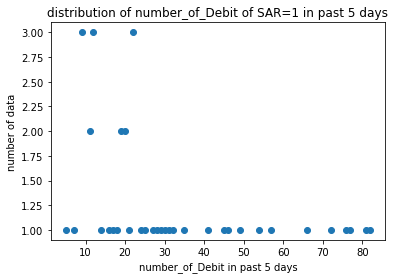

In [21]:
feature = 'number_of_Debit'
day = 5
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

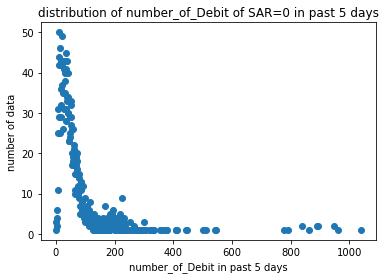

In [22]:
feature = 'number_of_Debit'
day = 5
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [24]:
# debit 提款次數 小於等於{次數}留下, upper bound
# train set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

threshold_range2 = np.arange(10, 220, 20)

for thre in threshold_range2:
    new_SAM_1 = train_set[train_set['number_of_Debit']<=thre]
    new_SAM_0 = train_set[train_set['number_of_Debit']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,10,43,2660,5,177,38,2483,0.1163,0.9327
1,30,43,2660,28,923,15,1737,0.6512,0.6482
2,50,43,2660,35,1574,8,1086,0.814,0.4047
3,70,43,2660,38,1972,5,688,0.8837,0.2564
4,90,43,2660,43,2193,0,467,1.0,0.1728
5,110,43,2660,43,2298,0,362,1.0,0.1339
6,130,43,2660,43,2364,0,296,1.0,0.1095
7,150,43,2660,43,2402,0,258,1.0,0.0954
8,170,43,2660,43,2439,0,221,1.0,0.0818
9,190,43,2660,43,2497,0,163,1.0,0.0603


In [25]:
# test
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 90
new_SAM_1 = test_set[test_set['number_of_Debit']<=thre] # <threshold留下
new_SAM_0 = test_set[test_set['number_of_Debit']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,90,30,1774,25,1492,5,282,0.8333,0.1591


### threshold: 存入交易(現金、支票、定存、黃金、轉帳、匯款)次數>=&1701_trans_num_cr次

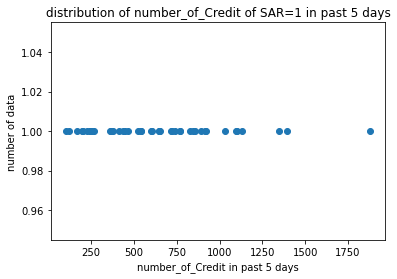

In [26]:
feature = 'number_of_Credit'
day = 5
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

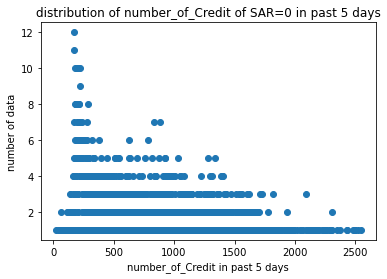

In [27]:
feature = 'number_of_Credit'
day = 5
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [28]:
# threshold: 存入交易次數 小於等於{次數}留下, upper bound
# train
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

threshold_range3 = np.arange(1000, 2000, 100)
for thre in threshold_range3:
    new_SAM_1 = train_set[train_set['number_of_Credit']<=thre] 
    new_SAM_0 = train_set[train_set['number_of_Credit']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,1000,43,2660,36,1853,7,807,0.8372,0.3011
1,1100,43,2660,39,1982,4,678,0.907,0.2523
2,1200,43,2660,40,2095,3,565,0.9302,0.2101
3,1300,43,2660,40,2207,3,453,0.9302,0.1687
4,1400,43,2660,42,2328,1,332,0.9767,0.1232
5,1500,43,2660,42,2404,1,256,0.9767,0.0951
6,1600,43,2660,42,2476,1,184,0.9767,0.0684
7,1700,43,2660,42,2545,1,115,0.9767,0.0429
8,1800,43,2660,42,2587,1,73,0.9767,0.0274
9,1900,43,2660,43,2603,0,57,1.0,0.0211


In [29]:
# test set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 1100
new_SAM_1 = test_set[test_set['number_of_Credit']<=thre] 
new_SAM_0 = test_set[test_set['number_of_Credit']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,1100,30,1774,30,1151,0,623,1.0,0.3453


### threshold: 移出金額除以存入金額"比例介於&1701_ratio_lower~&1701_ratio_upper

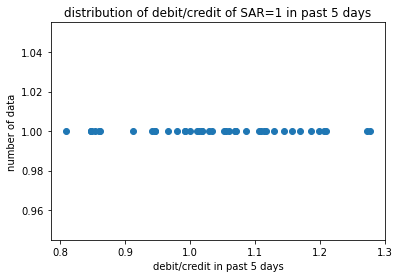

In [30]:
feature = 'debit/credit'
day = 5
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

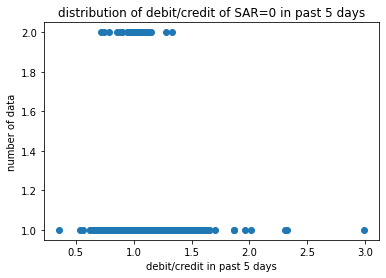

In [31]:
feature = 'debit/credit'
day = 5
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [36]:
# threshold: 移出金額除以存入金額 小於等於{ratio}留下, upper bound
# credit 存款
# train
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

threshold_range4 = np.arange(0.5,2.7, 0.2)
for thre in threshold_range4:
    new_SAM_1 = train_set[train_set['debit/credit']<=thre] # >threshold留下
    new_SAM_0 = train_set[train_set['debit/credit']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,0.5,43,2660,0,1,43,2659,0.0,0.9996
1,0.7,43,2660,0,14,43,2646,0.0,0.9948
2,0.9,43,2660,7,371,36,2289,0.1628,0.8602
3,1.1,43,2660,29,2069,14,591,0.6744,0.2238
4,1.3,43,2660,43,2555,0,105,1.0,0.0388
5,1.5,43,2660,43,2627,0,33,1.0,0.0122
6,1.7,43,2660,43,2652,0,8,1.0,0.003
7,1.9,43,2660,43,2655,0,5,1.0,0.0018
8,2.1,43,2660,43,2657,0,3,1.0,0.0011
9,2.3,43,2660,43,2657,0,3,1.0,0.0011


In [37]:
# test set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 1.3
new_SAM_1 = test_set[test_set['debit/credit']<=thre] # >threshold留下
new_SAM_0 = test_set[test_set['debit/credit']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,1.3,30,1774,30,1743,0,31,1.0,0.0172
